In [1]:
from sklearn import metrics
import numpy as np
import torch
import argparse
from collections import namedtuple
# import wandb
import os
from torchmetrics import Accuracy

import change_detection_pytorch as cdp
from change_detection_pytorch.datasets import LEVIR_CD_Dataset

from change_detection_pytorch.encoders._utils import adjust_state_dict_prefix

from torch.utils.data import DataLoader

from change_detection_pytorch.datasets import ChangeDetectionDataModule
from argparse import ArgumentParser

from change_detection_pytorch.datasets import UCMerced, build_transform

from dataclasses import dataclass

from matplotlib import pyplot as plt
from tqdm import tqdm

import train_classifier as tr_cls

cuda:0


In [2]:
@dataclass
class Args:
    device: int = 1
    experiment_name: str = 'tmp'
    
    backbone_name: str = 'ibot-B'
    encoder_weights: str = 'million_aid_fa'
    encoder_depth: int = 12
    in_features: int =768
    
    root: str = '/nfs/ap/mnt/sxtn/classification/datasets/'
    base_dir: str = 'UCMerced_LandUse/Images/'
    dataset_name: str = 'uc_merced'
    num_classes: int = 21
    
    fusion: str = 'diff'
    scale: str = None
    mode: str = 'vanilla'
    batch_size: int = 32

In [10]:
checkpoints = [
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_merced_mixup/epoch=89.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_merced/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_mixup/epoch=99.ckpt',
     # '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99.ckpt',   
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_resisc/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_resisc/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_resisc/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_resisc/epoch=24.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99-v3.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced_head/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_hr_merced/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_merced_all_model/epoch=99.ckpt',
    # '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt',
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt',
    '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_hr_merced_only_head/epoch=99.ckpt',
    '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_merced_all_model/epoch=99.ckpt'
]

In [4]:
pth = '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99-v3.ckpt'
checkpoint = torch.load(pth, map_location='cuda' if torch.cuda.is_available() else 'cpu')
print(checkpoint['state_dict'].keys())

In [ ]:
results = {}
scales = ['1x', '2x', '4x', '8x']

for checkpoint_path in checkpoints:
    results[checkpoint_path] = {}
    for scale in scales:
        
        args = Args()
    
        if 'gfm' in checkpoint_path:
            args.backbone_name = 'Swin-B'
            args.encoder_weights = 'geopile'
            args.in_features = 1024
        elif 'satlas' in checkpoint_path:
            args.backbone_name = 'Swin-B'
            args.encoder_weights = 'satlas'
            args.in_features = 1024

        if '_resisc' in checkpoint_path:
            args.root = "/nfs/ap/mnt/sxtn/classification/datasets/"
            args.base_dir = "NWPU-RESISC45/"
            args.dataset_name = "resisc45"
            args.num_classes = 45

        if scale != '1x':
            args.scale = scale
            args.base_dir = args.base_dir[:-1] + '_' + scale + args.base_dir[-1]
            
        print(args)

        test_transform = build_transform(split='test')
        test_dataset = UCMerced(root=args.root, base_dir=args.base_dir, split='test', transform=test_transform, dataset_name=args.dataset_name)
        test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=8)

        if 'satlas' in checkpoint_path:
            model = tr_cls.Classifier(backbone_name=args.backbone_name, backbone_weights=args.encoder_weights, 
                                  in_features=args.in_features, num_classes=args.num_classes, 
                                  lr=0.0, sched='', checkpoint_path=checkpoint_path, only_head='', prefix='encoder')
        else:
            model = tr_cls.Classifier(backbone_name=args.backbone_name, backbone_weights=args.encoder_weights, 
                                  in_features=args.in_features, num_classes=args.num_classes, 
                                  lr=0.0, sched='', checkpoint_path='', only_head='')

        checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
        if 'satlas' not in checkpoint_path:
            model.load_state_dict(checkpoint['state_dict'])


        model.eval()
        
        test_accuracy = Accuracy(task="multiclass", num_classes=args.num_classes)

        with torch.no_grad():
            correct_predictions = 0
            total_samples = 0
            for batch in tqdm(test_dataloader):
                x, y = batch
                logits = model(x)
                batch_accuracy = test_accuracy(torch.argmax(logits, dim=1), y)
                correct_predictions += batch_accuracy.item() * len(y)
                total_samples += len(y)
        
            overall_test_accuracy = correct_predictions / total_samples
        print(checkpoint_path)
        print(f'Test Accuracy: {overall_test_accuracy * 100:.2f}%')
        results[checkpoint_path][scale] = overall_test_accuracy * 100
print(results)

Args(device=1, experiment_name='tmp', backbone_name='ibot-B', encoder_weights='million_aid_fa', encoder_depth=12, in_features=768, root='/nfs/ap/mnt/sxtn/classification/datasets/', base_dir='UCMerced_LandUse/Images/', dataset_name='uc_merced', num_classes=21, fusion='diff', scale=None, mode='vanilla', batch_size=32)
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:19<00:00,  5.71s/it]


/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt
Test Accuracy: 41.43%
Args(device=1, experiment_name='tmp', backbone_name='ibot-B', encoder_weights='million_aid_fa', encoder_depth=12, in_features=768, root='/nfs/ap/mnt/sxtn/classification/datasets/', base_dir='UCMerced_LandUse/Images_2x/', dataset_name='uc_merced', num_classes=21, fusion='diff', scale='2x', mode='vanilla', batch_size=32)
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:21<00:00,  5.80s/it]


/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt
Test Accuracy: 43.33%
Args(device=1, experiment_name='tmp', backbone_name='ibot-B', encoder_weights='million_aid_fa', encoder_depth=12, in_features=768, root='/nfs/ap/mnt/sxtn/classification/datasets/', base_dir='UCMerced_LandUse/Images_4x/', dataset_name='uc_merced', num_classes=21, fusion='diff', scale='4x', mode='vanilla', batch_size=32)
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:22<00:00,  5.93s/it]


/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt
Test Accuracy: 38.57%
Args(device=1, experiment_name='tmp', backbone_name='ibot-B', encoder_weights='million_aid_fa', encoder_depth=12, in_features=768, root='/nfs/ap/mnt/sxtn/classification/datasets/', base_dir='UCMerced_LandUse/Images_8x/', dataset_name='uc_merced', num_classes=21, fusion='diff', scale='8x', mode='vanilla', batch_size=32)
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


 29%|██████████████████████████████████                                                                                     | 4/14 [00:26<01:05,  6.50s/it]

In [7]:
print(results)

{'/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99-v3.ckpt': {'1x': 81.66666666666667, '2x': 74.04761904761905, '4x': 47.61904761904761, '8x': 28.57142857142857}, '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced_head/epoch=99.ckpt': {'1x': 86.90476190476191, '2x': 80.0, '4x': 52.61904761904762, '8x': 27.142857142857142}, '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_hr_merced/epoch=99.ckpt': {'1x': 97.61904761904762, '2x': 94.76190476190476, '4x': 80.47619047619048, '8x': 35.476190476190474}, '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_merced_all_model/epoch=99.ckpt': {'1x': 67.85714285714286, '2x': 64.76190476190476, '4x': 53.333333333333336, '8x': 32.38095238095238}, '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt': {'1x': 41.42857142857143, '2x': 43.333333333333336, '4x': 38.57142857142858, '8x': 25.71428571428571}}


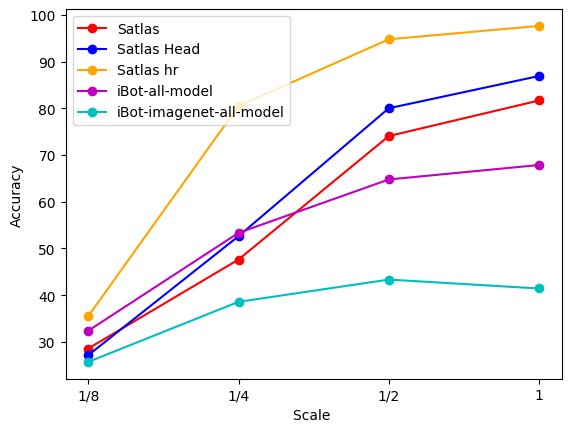

In [9]:
# UC MERCED NEW RESULTS

results_saved = {
    '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99-v3.ckpt': {
        '1x': 81.66666666666667, 
        '2x': 74.04761904761905, 
        '4x': 47.61904761904761, 
        '8x': 28.57142857142857
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced_head/epoch=99.ckpt': {
        '1x': 86.90476190476191, 
        '2x': 80.0, 
        '4x': 52.61904761904762, 
        '8x': 27.142857142857142
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_hr_merced/epoch=99.ckpt': {
        '1x': 97.61904761904762, 
        '2x': 94.76190476190476, 
        '4x': 80.47619047619048, 
        '8x': 35.476190476190474
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_merced_all_model/epoch=99.ckpt': {
        '1x': 67.85714285714286, 
        '2x': 64.76190476190476, 
        '4x': 53.333333333333336, 
        '8x': 32.38095238095238
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt': {
        '1x': 41.42857142857143, 
        '2x': 43.333333333333336, 
        '4x': 38.57142857142858, 
        '8x': 25.71428571428571
    }
}


satlas_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99-v3.ckpt'].values())
satlas_head_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced_head/epoch=99.ckpt'].values())
satlas_hr_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/satlas_hr_merced/epoch=99.ckpt'].values())
ibot_all_model_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_merced_all_model/epoch=99.ckpt'].values())
ibot_imagenet_all_model_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_all_model/epoch=99.ckpt'].values())

x_values = ['1/8', '1/4', '1/2', '1']

# Plotting the data
plt.plot(x_values, satlas_results[::-1], marker='o', color='red', label='Satlas')
plt.plot(x_values, satlas_head_results[::-1], marker='o', color='blue', label='Satlas Head')
plt.plot(x_values, satlas_hr_results[::-1], marker='o', color='orange', label='Satlas hr')
plt.plot(x_values, ibot_all_model_results[::-1], marker='o', color='m', label='iBot-all-model')
plt.plot(x_values, ibot_imagenet_all_model_results[::-1], marker='o', color='c', label='iBot-imagenet-all-model')


# Adding labels and title
plt.xlabel('Scale ')
plt.ylabel('Accuracy')
# plt.title('Accuracy Comparison between ibot and gfm')
plt.legend()

# Display the plot
plt.show()
                 

In [ ]:
# UC MERCED RESULTS

results_saved = {
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_merced_mixup/epoch=89.ckpt': {
        '1x': 98.80952380952381,
        '2x': 98.33333333333333,
        '4x': 50.95238095238095,
        '8x': 11.666666666666666
    },
    '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_merced/epoch=99.ckpt': {
        '1x': 94.76190476190476,
        '2x': 91.42857142857143,
        '4x': 78.0952380952381,
        '8x': 43.333333333333336
    },
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_mixup/epoch=99.ckpt': {
        '1x': 98.09523809523809, 
        '2x': 98.33333333333333, 
        '4x': 90.47619047619048, 
        '8x': 65.23809523809524
    },
    '/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99.ckpt': {
        '1x': 41.42857142857143, 
        '2x': 39.76190476190476, 
        '4x': 36.666666666666664, 
        '8x': 27.61904761904762
    }
}

ibot_millionAID_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_merced_mixup/epoch=89.ckpt'].values())
gfm_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/gfm_merced/epoch=99.ckpt'].values())
ibot_imagenet_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_merced_mixup/epoch=99.ckpt'].values())
satlas_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/satlas_merced/epoch=99.ckpt'].values())

x_values = ['1/8', '1/4', '1/2', '1']

# Plotting the data
plt.plot(x_values, gfm_results[::-1], marker='o', color='red', label='GFM')
plt.plot(x_values, ibot_millionAID_results[::-1], marker='o', color='blue', label='iBot-millionAID')
plt.plot(x_values, satlas_results[::-1], marker='o', color='orange', label='Satlas')
plt.plot(x_values, ibot_imagenet_results[::-1], marker='o', color='m', label='iBot-imagenet')


# Adding labels and title
plt.xlabel('Scale ')
plt.ylabel('Accuracy')
# plt.title('Accuracy Comparison between ibot and gfm')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# RESISC RESULTS
results_saved = {
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_resisc/epoch=99.ckpt': {
        '1x': 93.80952381709265, 
        '2x': 87.11111111489554, 
        '4x': 26.619047617155406, 
        '8x': 7.492063493482651
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_resisc/epoch=99.ckpt': {
        '1x': 91.58730158351716, 
        '2x': 89.44444444822886, 
        '4x': 74.69841270598154, 
        '8x': 40.30158729780288
    }, 
    '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_resisc/epoch=99.ckpt': {
        '1x': 90.42857143235585, 
        '2x': 85.4444444368756, 
        '4x': 64.87301587301587, 
        '8x': 29.85714285714286
    }
}

ibot_millionAID_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_fa_resisc/epoch=99.ckpt'].values())
gfm_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/ibot_imagenet_resisc/epoch=99.ckpt'].values())
ibot_imagenet_results = list(results_saved['/auto/home/ani/change_detection.pytorch/checkpoints/gfm_resisc/epoch=99.ckpt'].values())

x_values = ['1/8', '1/4', '1/2', '1']

# Plotting the data
plt.plot(x_values, ibot_millionAID_results[::-1], marker='o', color='red', label='ibot-millionAID_results')
plt.plot(x_values, gfm_results[::-1], marker='o', color='blue', label='gfm')
plt.plot(x_values, ibot_imagenet_results[::-1], marker='o', color='orange', label='ibot-imagenet_results')

# Adding labels and title
plt.xlabel('Scale ')
plt.ylabel('Accuracy')
# plt.title('Accuracy Comparison between ibot and gfm')
plt.legend()

# Display the plot
plt.show()